# **Modelling and Evaluation**
---

## Objective

- Answer business requirement 2:
    * The client needs a tool that can tell their pets apart based on live image data.

## Inputs

- The folder `inputs/datasets/pets` containing the subfolders `train`, `test`, and `validation`
- The correctly labelled folders in each of these subfolders
- An adequate amount of preprocessed png images (size 450x450) in each labelled folder, showing a close-up of the pet's face
- Image shape file

## Outputs

- Images distribution plot in train, validation, and test set
- Image augmentation
- Class indices
- Results of ML hyperparameter optimization
- Machine learning model creation and training
- Saved model
- Learning curve plot for model performance
- Model evaluation in pickle file
- Prediction on test data
- Prediction on live data

---
## Preparation

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread
from tensorflow.keras.preprocessing import image
from PIL import Image
import shutil
import random
import tensorflow as tf

sns.set_style("white")


### Set the correct working directory

In [2]:
# Check the current working directory; os.chdir to change working directory if needed
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5\\jupyter_notebooks'

In [3]:
# Move up to the project top directory
os.chdir(os.path.dirname(cwd))
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5'

In [4]:
# Current folder name with raw images
img_dir = 'pets'

### Set the main paths and constant variables

In [5]:
dataset_name = "pets"
full_dataset_path = os.path.normpath(os.path.join(cwd, 'inputs/datasets', dataset_name))
output_path = os.path.join(cwd, 'outputs')
train_path = os.path.join(full_dataset_path, 'train')
test_path = os.path.join(full_dataset_path, 'test')
validation_path = os.path.join(full_dataset_path, 'validation')

INPUT_SHAPE = joblib.load(f'{output_path}/input_shape.pkl')
CLASS_DICT = joblib.load(f'{output_path}/class_dict.pkl')
LABELS = sorted(CLASS_DICT.values())

# The following line should show a list containing the subsets of the split dataset
print(os.listdir(full_dataset_path))

print(INPUT_SHAPE)
print(LABELS)

['test', 'train', 'validation']
(-1, 128, 128, 3)
['fin', 'iris', 'smilla']


### Util functions
####  Highlight errors and warnings

In [6]:
from colorama import Fore, Style

# Error notification style
def print_err(message='', e=None):
    print(f'{Fore.RED}ERROR:{Style.RESET_ALL}\n{message}')
    if e:
        print(f'{os.strerror(e.errno)}: {e.filename}')

# Warning notification style
def print_warn(message):
    print(f'{Fore.YELLOW}WARNING:{Style.RESET_ALL}\n{message}')

#### Style DataFrame text output

In [7]:
def style_dataframe(df, hl_label=None):
    col_names = [' ']
    col_names.extend(list(df.columns))
    for x, c in enumerate(col_names):
        if x == 0:
            print(f'\033[1m{c:>8}\033[0m', end='')
        else:
            print(f'\033[1m{c.upper():>13}\033[0m', end='')
    print(f'\n{"-"*60}')
    for i in df.index:
        if i == hl_label:
            hl = Fore.GREEN
        else:
            hl = ''
        print(f'\033[1m{hl}{i:<8}\033[0m', end='')
        for c in df.columns:
            print(f'{hl if c == 'train' else ''}{df[c][i]:>13}\033[0m', end='')
        print('')

#### Display a progress bar

In [8]:
def show_progress(list_len):
    width = 100
    for i in range(list_len):
        yield f'\r{"#"*int(width if i == list_len-1 else i//(list_len/width)):<{width}}|| '


#### Remove tick characters from plots

In [9]:
def set_ticks(ax):
    ax.axis('on')
    ax.set_xticks([])
    ax.set_yticks([])


--- 
## Step 1: Balance data

In case the dataset is still unbalanced at this point and no more raw data can be collected and added, we can use other methods to balance the labels:
- Use class weights when fitting the model
- Undersample the labels with most data
- Oversample and augment the data

Let's take a look at the current distribution numbers:

### Check label distribution


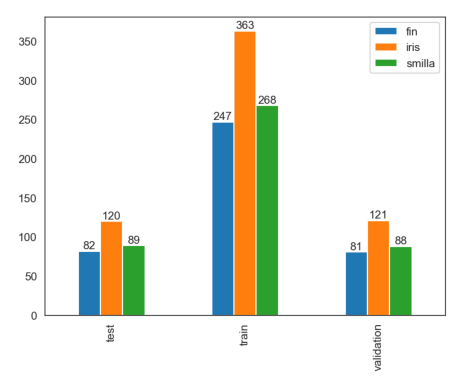

                 TEST        TRAIN   VALIDATION
------------------------------------------------------------
fin                82          247           81
iris              120          363          121
smilla             89          268           88


In [10]:
try:
    dataset_stats = joblib.load(os.path.join(output_path, f'labels_distribution.pkl'))
    dataset_plot = Image.open(os.path.join(output_path, f'labels_distribution_after_split.png'))
except FileNotFoundError as e:
    print_err(e=e)
plt.axis('off')
plt.imshow(dataset_plot)
plt.show()

df = pd.DataFrame(dataset_stats)
style_dataframe(df)


### Calculate augmentation values

In this case, we decide to balance the data through augmentation and oversampling.

*Note:*
Should the application of class weights make more sense for a specific dataset, the following code can be run after the creation of the `y_train` variable and added to the `model.fit()` function as the `class_weight` parameter, to be used with a one-hot encoded list of labels:

```python
    from sklearn.utils import class_weight

    weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(weights))
```


In [34]:
from sklearn.preprocessing import normalize

def get_augment_amounts(aug_percentage, stats, batch=None):
    aug_stats = {}
    df = pd.DataFrame(stats)
    print('Current image distribution in the input dataset:\n')
    
    max_train_amount = df['train'].max() if not batch else batch
    max_train_label = df['train'].idxmax()

    style_dataframe(df, max_train_label)

    print(f'\nLabel with the most images: {max_train_label} - {df['train'].max()} images\n')
    print(f'During the sampling of the original image data, the amount will be capped at '
          f'{Fore.GREEN}{batch}{Fore.RESET}.\n')

    try:
        folders, ratios = joblib.load(f'{output_path}/split_folder_ratio.pkl')
    except FileNotFoundError as e:
        print_err(e=e)
        
    ratios = normalize([list(ratios)], norm='max').reshape(-1)
    split_ratios = pd.Series(dict(zip(folders, ratios)))
    print(f'Normalized split ratios between the train, test, and validation subsets: \n{split_ratios.map("{:,.2f}".format).to_string()}')
    max_augment = int(max_train_amount * (1 + aug_percentage))
    print(f'\nYou chose to augment the majority label by {Fore.GREEN}{aug_percentage*100}%{Fore.RESET}.\n'
          f'After the augmentation, each label in the training set will contain '
          f'{Fore.GREEN}{max_augment}{Fore.RESET} images.')

    for col in split_ratios.keys():
        aug_stats[col] = {}
        for idx in df[col].index:
            if batch and idx == max_train_label and df['train'][idx] > batch:
                aug_stats[col][idx] = int((max_augment - max_train_amount) * split_ratios[col] * -1)
            else:
                if df['train'][idx] > max_label_cap:
                    aug_stats[col][idx] = int((max_augment - max_train_amount) * split_ratios[col] * -1)
                else:
                    aug_stats[col][idx] = int(max_augment * split_ratios[col] - df[col][idx])
    
    return aug_stats

# By how many percent should the largest label be augmented?
max_label_cap = 400
aug_stats = get_augment_amounts(0.3, dataset_stats, batch=max_label_cap)
print('The following amounts of images need to be added to each label:\n')
style_dataframe(pd.DataFrame(aug_stats))
print(f'\nIf the amount is negative, the sampling of the original images for this label '
      f'will be \ncapped at {max_label_cap} and the label will be augmented with the '
      f'amount shown.')


Current image distribution in the input dataset:

                 TEST        TRAIN   VALIDATION
------------------------------------------------------------
fin                82          247           81
iris              120          363          121
smilla             89          268           88

Label with the most images: iris - 363 images

During the sampling of the original image data, the amount will be capped at 400.

Normalized split ratios between the train, test, and validation subsets: 
train         1.00
test          0.33
validation    0.33

You chose to augment the majority label by 30.0%.
After the augmentation, each label in the training set will contain 520 images.
The following amounts of images need to be added to each label:

                TRAIN         TEST   VALIDATION
------------------------------------------------------------
fin               273           91           92
iris              157           53           52
smilla            252           84

## Step 2: Load data

In [35]:
# Load all images from specified folder, resize them, save them as np array in X and save their labels in y
from tensorflow.keras.layers import RandomBrightness
import tensorflow as tf
#tf.config.run_functions_eagerly(True)


def augment_label(path, subset, extra_amount, X, y, dims, label, img_list):
    print(f'Adding augmented images for label {label} ...')
    #extra_amount = abs(aug_stats[subset][label])
    extra_list = np.random.choice(img_list, size=extra_amount, replace=True)
    rand_brightness = RandomBrightness([-0.15, 0.15], seed=42)
    counters = {'brightness': 0, 'crop': 0, 'hue': 0}

    list_len = len(extra_list)
    progress_bar = show_progress(list_len)

    for img_name in extra_list:
        img = image.load_img(os.path.join(path, label, img_name))

        brightness_adjust = True if random.random() <= 0.6 else False
        crop_adjust = True if random.random() <= 0.6 else False

        if crop_adjust:
            crop_px = random.randint(5, 15)
            offset = random.randint(0, 5)
            img = img.crop((crop_px, crop_px+offset, dims[0]-crop_px, dims[1]-(crop_px-offset)))
            counters['crop'] += 1
            img = img.resize(dims, resample=Image.LANCZOS)

        img_arr = image.img_to_array(img)
        
        # Only the train images will be adjusted with noise, random brightness and hue
        if subset == 'train':
            if brightness_adjust:
                img_arr = rand_brightness(img_arr).numpy()
                counters['brightness'] += 1

            if img_arr.max() > 1:
                img_arr = img_arr / 255.0

            # Change hue and add noise for each channel
            # Small std means less noise
            std = 0.03
            mean = 0
            for ch in [0, 1, 2]:
                # Add a layer of random noise to each channel
                gaussian = np.random.normal(mean, std, dims)
                hue_changed = False
                if random.random() < 0.2:
                    # 20% chance of not changing hue, only add noise
                    img_arr[:, :, ch] = np.clip(img_arr[:, :, ch] + gaussian, 0, 1)
                    continue
        
                hue = random.randrange(-15, 15)/100.0 #, random.randrange(-15, 15)/100.0, random.randrange(-15, 15)/100.0]
                img_flat = img_arr[..., ch].reshape(-1)
                img_hue = np.array([x + hue for x in img_flat]).reshape(dims)
                img_arr[..., ch] = np.clip(img_hue + gaussian, 0, 1)
                hue_changed = True

            if hue_changed:
                counters['hue'] += 1
        else:
            if img_arr.max() > 1:
                img_arr = img_arr / 255.0

        print(next(progress_bar), end='')

        X = np.append(X, img_arr)
        y = np.append(y, label)

    return X, y, counters, list_len



In [37]:

def save_images_in_array(path, subset, aug_stats, max_label_cap, shape):
    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    dims = tuple(shape[1:3])

    for label in os.listdir(path):
        print(f'Loading original images for label {label} ...')
        img_list = os.listdir(os.path.join(path, label))
        aug_amount = aug_stats[subset][label]
        
        try:
            folders, ratios = joblib.load(f'{output_path}/split_folder_ratio.pkl')
        except FileNotFoundError as e:
            print_err(e=e)
            
        ratios = normalize([list(ratios)], norm='max').reshape(-1)
        split_ratios = dict(zip(folders, ratios))
        # Undersample labels that are too large
        if aug_amount < 0:
            img_list = random.sample(img_list, k=int(max_label_cap*split_ratios[subset]))
        
        list_len = len(img_list)
        progress_bar = show_progress(list_len)

        for img_name in img_list:
            img = image.load_img(os.path.join(path, label, img_name))
            # if img.size != dims:
            #     img = img.resize(dims, resample=Image.LANCZOS)
            img_arr = image.img_to_array(img)
            if img_arr.max() > 1:
                img_arr = img_arr / 255.0

            # Add noise to train image set
            if subset == 'train':
                std = 0.03
                mean = 0
                gaussian = np.random.normal(mean, std, dims)
                noisy_image = np.zeros(img_arr.shape, np.float32)
                for ch in [0, 1, 2]:
                    noisy_image[:, :, ch] = img_arr[:, :, ch] + gaussian
                img_arr = np.clip(noisy_image, 0, 1).astype(np.float32)
                
            print(next(progress_bar), end='')

            X = np.append(X, img_arr)
            y = np.append(y, label)

        print(f'{list_len} images loaded')

        # Augment images:
        X, y, counters, aug_count = augment_label(path, subset, abs(aug_amount), X, y, dims, label, img_list)

        print(f'{aug_count} images loaded')

        print(f'\nAugmented label {label} by cropping {counters["crop"]} images, '
              f'adjusting brightness for {counters["brightness"]} images and '
              f'\nchanging hue for {counters["hue"]} images. '
              f'{"Noise has been added to all images." if subset == "train" else ""}')
        print(f'The {subset} subset for {label} contains {list_len + aug_count} images.\n')
        
    X = X.reshape(shape)
    
    # SMOTENC oversampling not useable: too many errors in the resulting images

    # Shuffle the resulting set
    zipped_set = list(zip(y, X))
    random.shuffle(zipped_set)
    y_shuffled, X_shuffled = list(map(list, zip(*zipped_set)))
    X = np.array(X_shuffled, dtype='float')
    y = np.array(y_shuffled, dtype='object')
    
    print(f'Resulting image set shape: {X.shape}, {y.shape} labels\n')
    
    return X, y



### Load train set

In [38]:
# Recreate the training set:
X_train, y_train = save_images_in_array(train_path, 'train', aug_stats, max_label_cap, INPUT_SHAPE)

Loading original images for label fin ...
####################################################################################################|| 247 images loaded
Adding augmented images for label fin ...
####################################################################################################|| 273 images loaded

Augmented label fin by cropping 180 images, adjusting brightness for 165 images and 
changing hue for 227 images. Noise has been added to all images.
The train subset for fin contains 520 images.

Loading original images for label iris ...
####################################################################################################|| 363 images loaded
Adding augmented images for label iris ...
####################################################################################################|| 157 images loaded

Augmented label iris by cropping 97 images, adjusting brightness for 96 images and 
changing hue for 121 images. Noise has been added to all images

#### Save train set shape

In [26]:
joblib.dump(X_train.shape, f'{output_path}/input_shape_loaded.pkl')

['d:\\Projekte\\Coding\\CodeInstitute\\PP5\\outputs/input_shape_loaded.pkl']

#### Show montage

In [39]:
import itertools

def show_subset_montage(X, y, subset, save=False):
    # Display a random batch of k images from the newly created subset
    img_sample = random.sample(range(0, X.shape[0]), k=9)
    coords = list(itertools.product(range(3), range(3)))
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    for coord, idx in zip(coords, list(img_sample)):
        axes[coord[0], coord[1]].set_title(y[idx])
        axes[coord[0], coord[1]].imshow(X[idx])
        set_ticks(axes[coord[0], coord[1]])
    plt.tight_layout(rect=[0, 0.02, 0.9, 0.97])
    if save:
        plt.savefig(f'{output_path}/post_augment_montage_{subset}.png', bbox_inches='tight', dpi=150)
    plt.show()

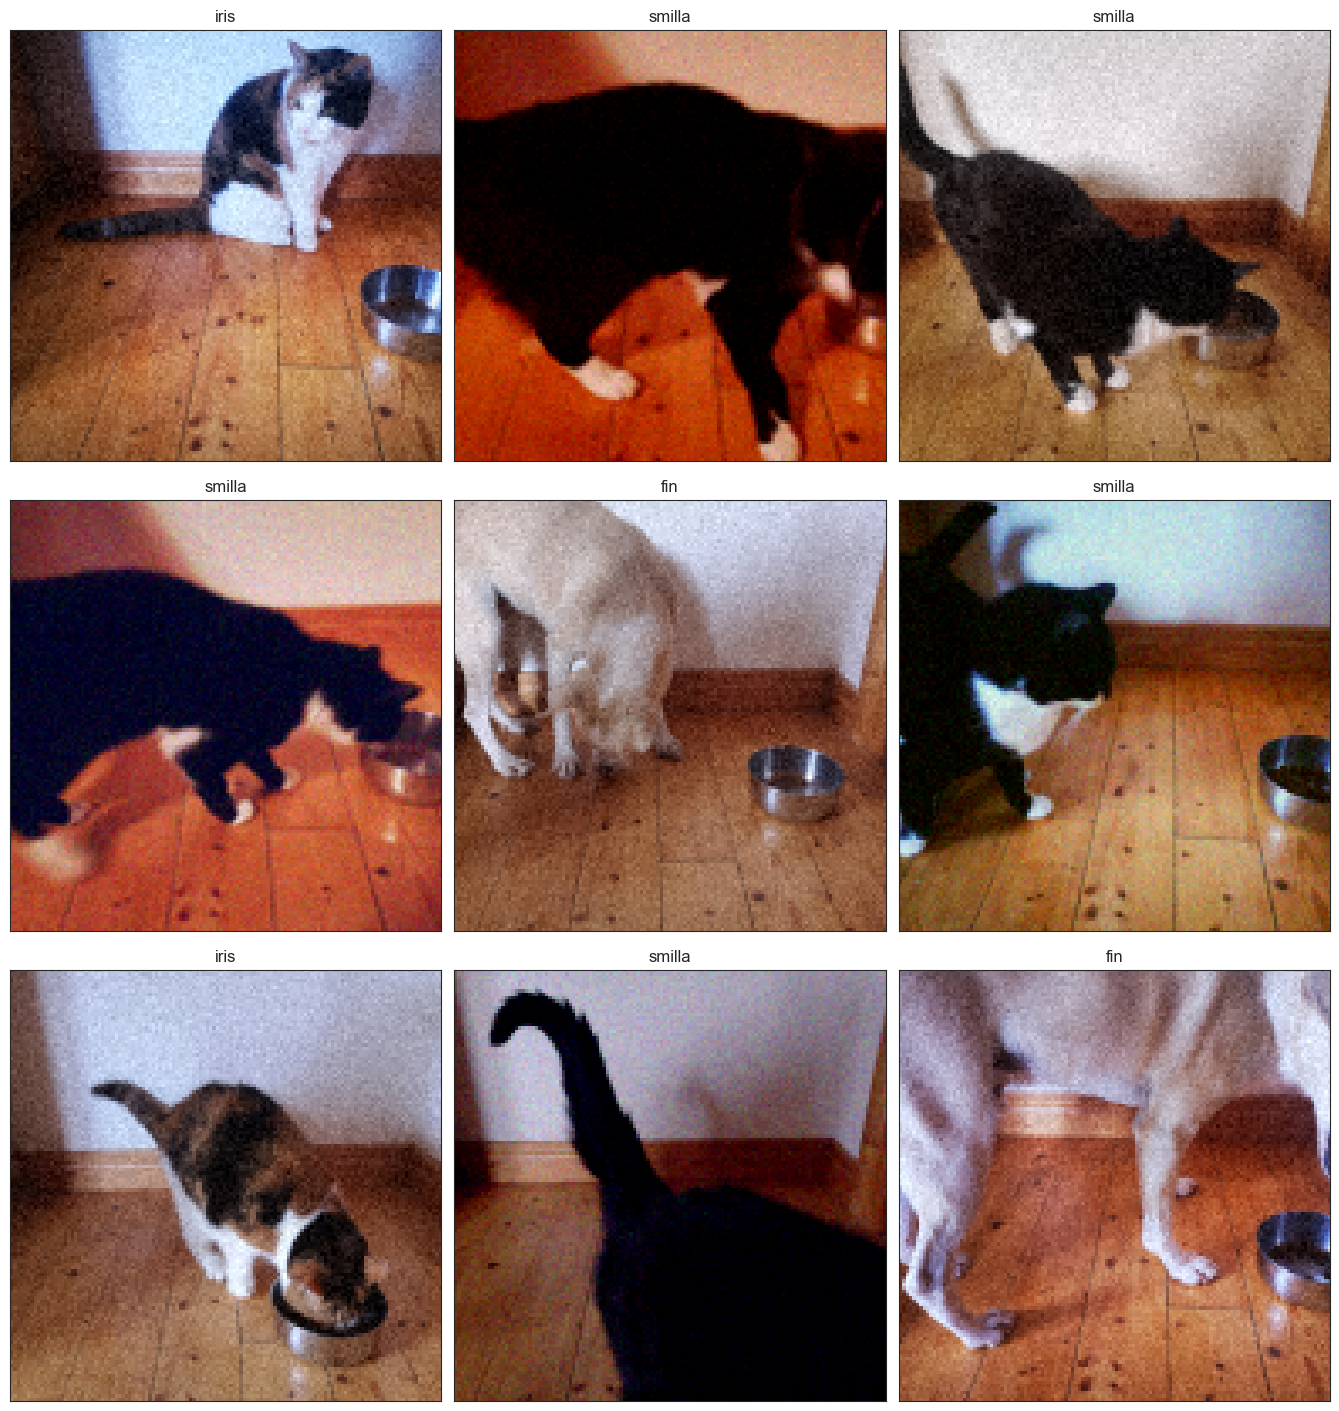

In [40]:
show_subset_montage(X_train, y_train, 'train')

### Load all other subsets

In [41]:
X_test, y_test = save_images_in_array(test_path, 'test', aug_stats, max_label_cap, INPUT_SHAPE)
X_val, y_val = save_images_in_array(validation_path, 'validation', aug_stats, max_label_cap, INPUT_SHAPE)

Loading original images for label fin ...
####################################################################################################|| 82 images loaded
Adding augmented images for label fin ...
####################################################################################################|| 91 images loaded

Augmented label fin by cropping 57 images, adjusting brightness for 0 images and 
changing hue for 0 images. 
The test subset for fin contains 173 images.

Loading original images for label iris ...
####################################################################################################|| 120 images loaded
Adding augmented images for label iris ...
####################################################################################################|| 53 images loaded

Augmented label iris by cropping 28 images, adjusting brightness for 0 images and 
changing hue for 0 images. 
The test subset for iris contains 173 images.

Loading original images for label

#### Show montages

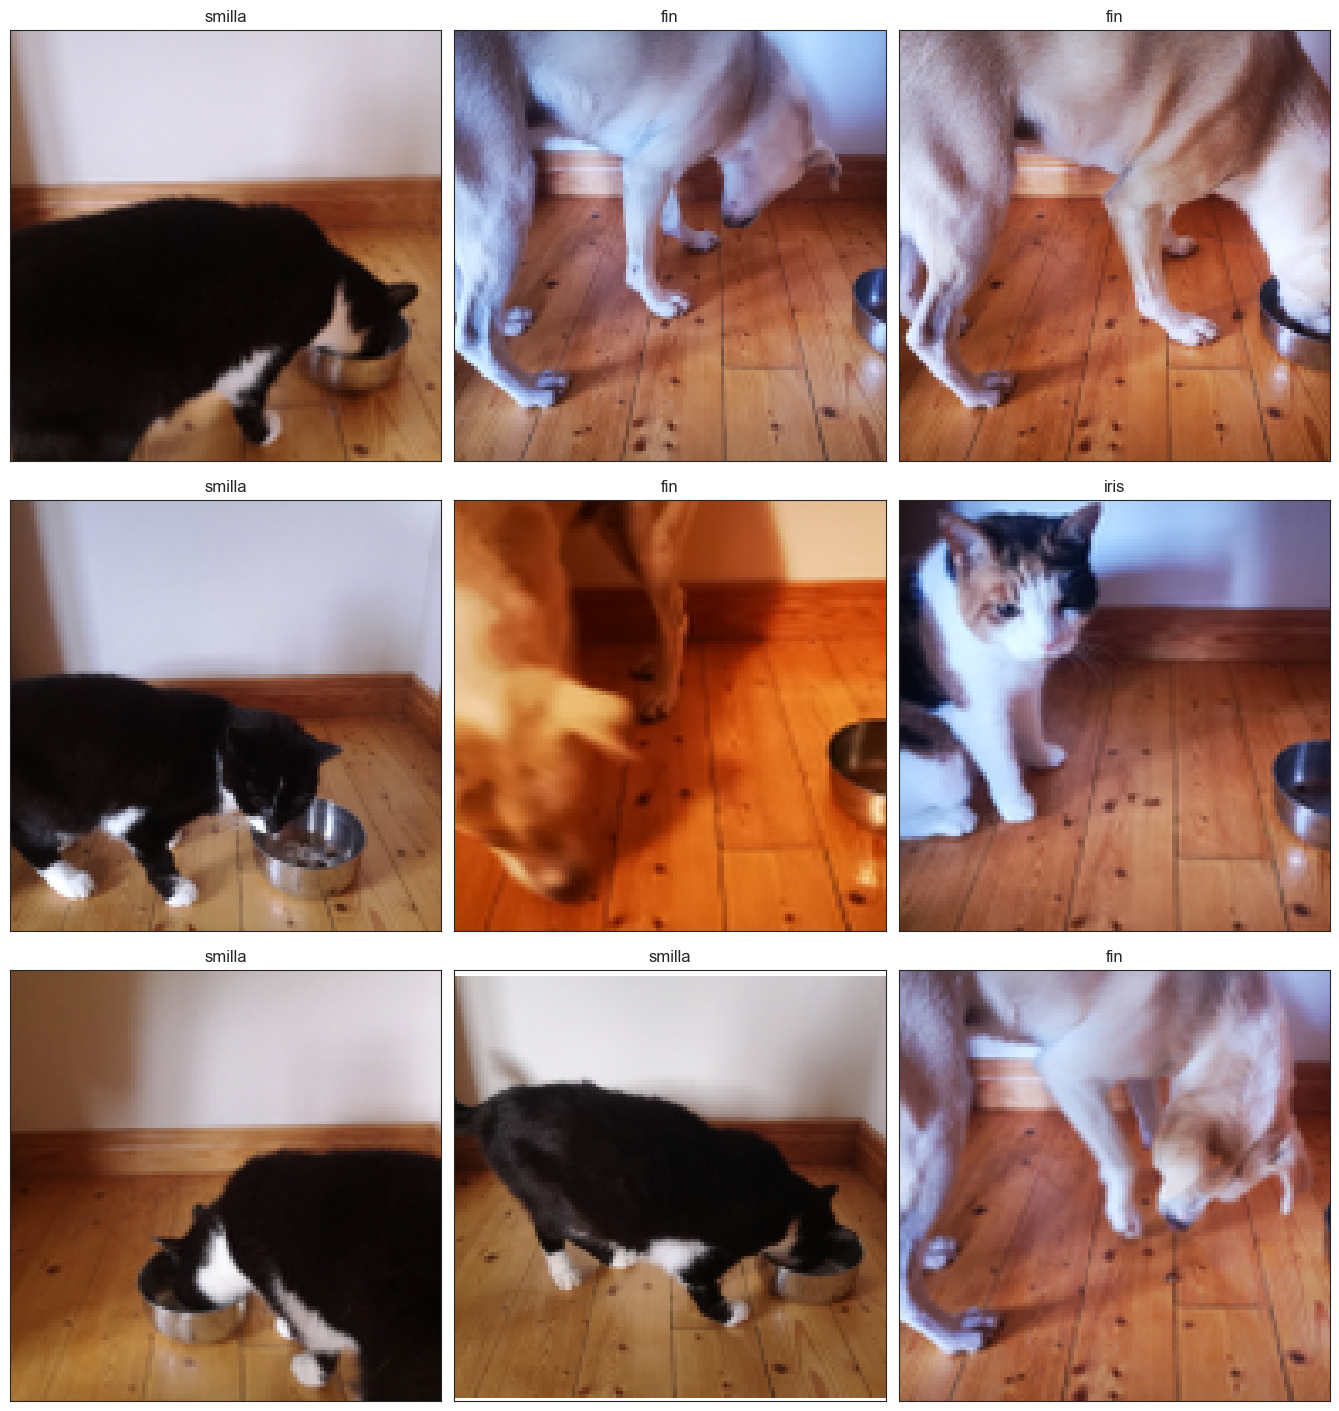

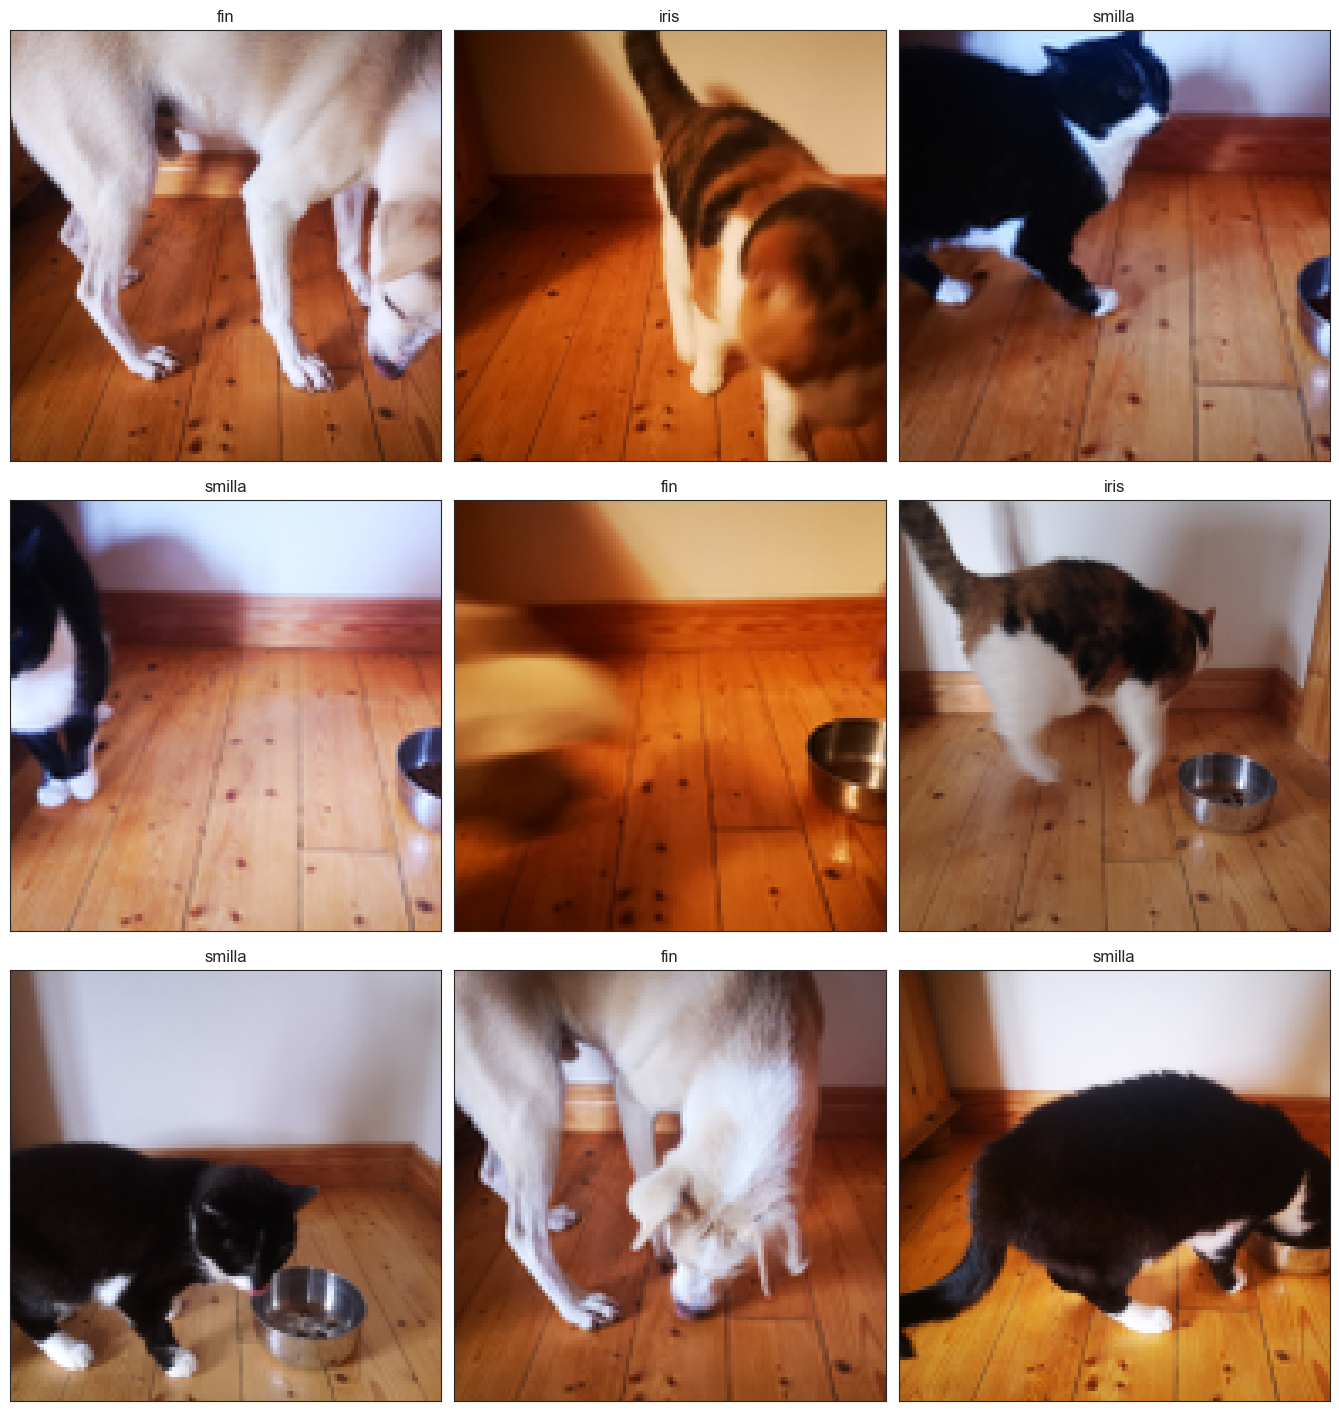

In [42]:
# Display a random batch of k images from the newly created validation and test sets
show_subset_montage(X_val, y_val, 'val')
show_subset_montage(X_test, y_test, 'test')

### One-hot encode all label arrays

In [189]:
y_ohe_train = pd.get_dummies(y_train, dtype='int')
y_ohe_test = pd.get_dummies(y_test, dtype='int')
y_ohe_val = pd.get_dummies(y_val, dtype='int')

# Check if the encoding has succeeded
print(y_ohe_train.head())
print(y_ohe_test.head())
print(y_ohe_val.head())

# Save the one-hot encoded categories for later use
ohe_enc = pd.get_dummies(LABELS, dtype='int')
ohe_map = {}
for idx, label in CLASS_DICT.items():
    ohe_map[label] = list(ohe_enc.iloc[idx])
joblib.dump(ohe_map, f'{output_path}/ohe_map.pkl')
print(ohe_map)

   fin  iris  smilla
0    1     0       0
1    0     1       0
2    0     0       1
3    0     0       1
4    0     1       0
   fin  iris  smilla
0    1     0       0
1    0     0       1
2    0     1       0
3    0     1       0
4    0     1       0
   fin  iris  smilla
0    0     1       0
1    0     1       0
2    0     0       1
3    0     0       1
4    1     0       0
{'fin': [1, 0, 0], 'iris': [0, 1, 0], 'smilla': [0, 0, 1]}


### (Optional) Save and load subsets

#### Save subsets and labels to files

In [46]:
def save_subsets_and_labels(X_train, X_test, X_val, y_ohe_train, y_ohe_test, y_ohe_val):
    joblib.dump(X_train, f'{output_path}/X_train.pkl')
    joblib.dump(X_test, f'{output_path}/X_test.pkl')
    joblib.dump(X_val, f'{output_path}/X_val.pkl')
    joblib.dump(y_ohe_train, f'{output_path}/y_ohe_train.pkl')
    joblib.dump(y_ohe_test, f'{output_path}/y_ohe_test.pkl')
    joblib.dump(y_ohe_val, f'{output_path}/y_ohe_val.pkl')

save_subsets_and_labels(X_train, X_test, X_val, y_ohe_train, y_ohe_test, y_ohe_val)

#### Load subsets and labels from files

In [15]:
# Load the image sets and OHE labels into memory if they already have been created:
def load_subsets_and_labels():
    X_train = joblib.load(f'{output_path}/X_train.pkl')
    X_test = joblib.load(f'{output_path}/X_test.pkl')
    X_val = joblib.load(f'{output_path}/X_val.pkl')
    y_ohe_train = joblib.load(f'{output_path}/y_ohe_train.pkl')
    y_ohe_test = joblib.load(f'{output_path}/y_ohe_test.pkl')
    y_ohe_val = joblib.load(f'{output_path}/y_ohe_val.pkl')
    
    return X_train, X_test, X_val, y_ohe_train, y_ohe_test, y_ohe_val

#X_train, X_test, X_val, y_ohe_train, y_ohe_test, y_ohe_val = load_subsets_and_labels()

## Step 3: Build the model

In [15]:
import tensorflow as tf
import keras_tuner
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, InputLayer
from tensorflow.keras.callbacks import EarlyStopping


In [92]:
# Optimize hyperparams
def test_model(hp):
    img_shape = INPUT_SHAPE[1:]
    output_classes = len(LABELS)

    model = Sequential()
    model.add(InputLayer(shape=img_shape))

    kern = hp.Int('kernel_1', min_value=3, max_value=6, step=1)
    model.add(Conv2D(filters=hp.Int('filters_1', min_value=32, max_value=128, step=32), kernel_size=(kern, kern), padding='same',
               activation='relu', ))
    pool = hp.Int('pool_1', min_value=2, max_value=5, step=1)
    model.add(MaxPooling2D(pool_size=(pool, pool)))

    model.add(Conv2D(filters=hp.Int('filters_2', min_value=64, max_value=128, step=32), kernel_size=(3, 3), padding='same',
               activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Optional third filter layer
    for i in range(0, hp.Int('num_filters', 0, 1)):
        model.add(Conv2D(filters=hp.Int('filters_3_' + str(i), min_value=64, max_value=256, step=32), kernel_size=(3, 3), padding='same',
                    activation='relu', ))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units_1', min_value=128, max_value=1024, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.4, max_value=0.7, step=0.1)))

    # Optional second dense layer
    for i in range(0, hp.Int('num_dense_layers', 0, 1)):
        model.add(Dense(hp.Int('dense_units_2', min_value=64, max_value=256, step=32), activation='relu'))
        model.add(Dropout(hp.Float('dropout_2', min_value=0.4, max_value=0.7, step=0.1)))

    model.add(Dense(output_classes, activation='softmax'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=['accuracy'])

    model.summary()

    return model


### Tune model

In [123]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
batch_size = 32

hp = keras_tuner.HyperParameters()
model = test_model(hp)

tuner = keras_tuner.BayesianOptimization(
    test_model,
    max_trials=20,
    objective="val_accuracy",
    directory="/tmp/tb",
    project_name='pets',
)

tuner.search(
    X_train,
    y_ohe_train,
    validation_data=(X_val, y_ohe_val),
    epochs=15,
    batch_size=batch_size,
    callbacks=[early_stop],
)

Trial 1 Complete [00h 03m 45s]
val_accuracy: 0.9558498859405518

Best val_accuracy So Far: 0.9558498859405518
Total elapsed time: 00h 03m 45s


### Save hyperparameters

In [51]:
#best_model = tuner.get_best_models(num_models=1)[0]

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(pd.Series(best_hyperparameters.values).to_string())
#hyperparams = {'kernel_1': 6, 'filters_1': 128, 'pool_1': 5, 'filters_2': 128, 'num_filters': 1, 'dense_units_1': 384, 'dropout_1': 0.6, 'learning_rate': 0.001, 'filters_3_0': 128}
#joblib.dump(hyperparams, f'{output_path}/hyperparam_values.pkl')
#print(pd.Series(hyperparams).to_string())
joblib.dump(best_hyperparameters.values, f'{output_path}/hyperparam_values.pkl')

kernel_1           6.000
filters_1        128.000
pool_1             5.000
filters_2        128.000
num_filters        1.000
dense_units_1    384.000
dropout_1          0.600
learning_rate      0.001
filters_3_0      128.000


### (Optional) Load pre-saved hyperparameter values

In [52]:
hyperparams = joblib.load(f'{output_path}/hyperparam_values.pkl')
print(pd.Series(hyperparams))

kernel_1           6.000
filters_1        128.000
pool_1             5.000
filters_2        128.000
num_filters        1.000
dense_units_1    384.000
dropout_1          0.600
learning_rate      0.001
filters_3_0      128.000
dtype: float64


## Step 4: Train the model

### Adapt and compile model

In [35]:
# Prepare model for saved hyperparams
def create_model(hyperparams):
    img_shape = INPUT_SHAPE[1:]
    output_classes = len(LABELS)

    model = Sequential()
    model.add(InputLayer(shape=img_shape))

    model.add(Conv2D(filters=hyperparams['filters_1'], kernel_size=(hyperparams['kernel_1'], hyperparams['kernel_1']), padding='same',
               activation='relu', ))
    model.add(MaxPooling2D(pool_size=(hyperparams['pool_1'], hyperparams['pool_1'])))

    model.add(Conv2D(filters=hyperparams['filters_2'], kernel_size=(3, 3), padding='same',
               activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=hyperparams['filters_3_0'], kernel_size=(3, 3), padding='same',
               activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(hyperparams['dense_units_1'], activation='relu'))
    model.add(Dropout(hyperparams['dropout_1']))
    
    model.add(Dense(output_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=hyperparams['learning_rate']),
                  metrics=['accuracy'])
    
    model.summary()

    return model



### Fit the model

In [36]:
model = create_model(hyperparams)

batch_size = 32

history = model.fit(X_train, y_ohe_train,
          epochs=15,
          validation_data=(X_val, y_ohe_val),
          verbose=1,
          batch_size=batch_size,
          )


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 128)  │        13,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 384)            │     1,769,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,080,131 (7.94 MB)

 Trainable params: 2,080,131 (7.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 678ms/step - accuracy: 0.5137 - loss: 0.9438 - val_accuracy: 0.8844 - val_loss: 0.3126
Epoch 2/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 616ms/step - accuracy: 0.8570 - loss: 0.3186 - val_accuracy: 0.9499 - val_loss: 0.1237
Epoch 3/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 614ms/step - accuracy: 0.9236 - loss: 0.1873 - val_accuracy: 0.9268 - val_loss: 0.1697
Epoch 4/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 609ms/step - accuracy: 0.9579 - loss: 0.1291 - val_accuracy: 0.9750 - val_loss: 0.0617
Epoch 5/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 608ms/step - accuracy: 0.9636 - loss: 0.0946 - val_accuracy: 0.9711 - val_loss: 0.0714
Epoch 6/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 621ms/step - accuracy: 0.9750 - loss: 0.0601 - val_accuracy: 0.9788 - val_loss: 0.0611
Epoch 7/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 614ms/step - accuracy: 0.9812 - loss: 0.0465 - val_accuracy: 0.9750 - val_loss: 0.0845
Epoch 8/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 624ms/step - accuracy: 0.9805 - loss: 0.0467 - val_accu

### Identify best epoch

In [37]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(f'Best epoch: {best_epoch}')

Best epoch: 8


### Retrain model

If the last epoch was not the best, retrain the model and stop at the best epoch.

In [ ]:
model = create_model(hyperparams)

history = model.fit(X_train, y_ohe_train,
          epochs=best_epoch,
          validation_data=(X_val, y_ohe_val),
          verbose=1,
          batch_size=batch_size,
          )

### Save the model

In [38]:
model.save(f'{output_path}/model_final.keras')

### (Optional) Load pre-saved model

In [11]:
model = tf.keras.models.load_model(f'{output_path}/model_final.keras')

## Step 5: Evaluate model

### Compare losses and accuracy

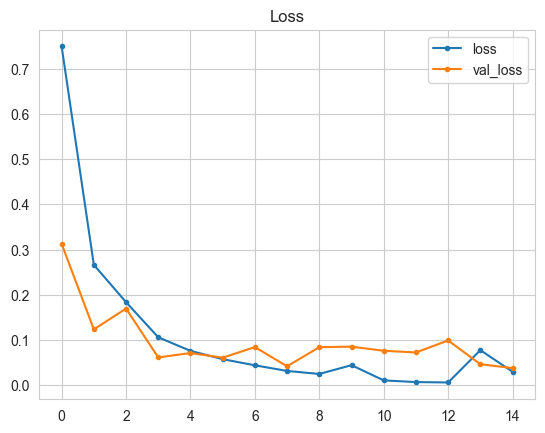

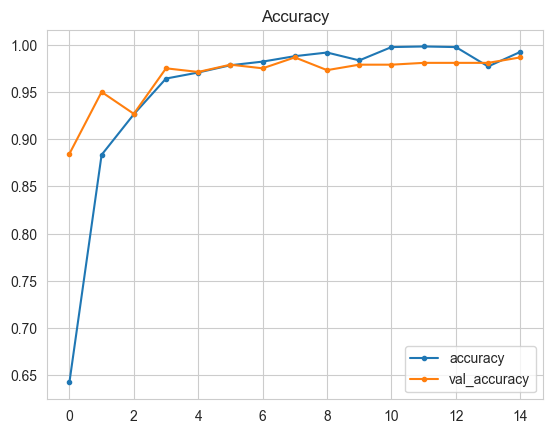

In [40]:
losses = pd.DataFrame(history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{output_path}/model_losses.png',
           bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{output_path}/model_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Evaluate based on test subset

In [41]:
eval = model.evaluate(X_test, y_ohe_test, verbose=3)
eval

[0.0343916192650795, 0.9807322025299072]

In [42]:
joblib.dump(eval, f'{output_path}/model_final_eval.pkl')

['d:\\Projekte\\Coding\\CodeInstitute\\PP5\\outputs/model_final_eval.pkl']

## Step 6: Make predictions
### Predict classes for a test image sample

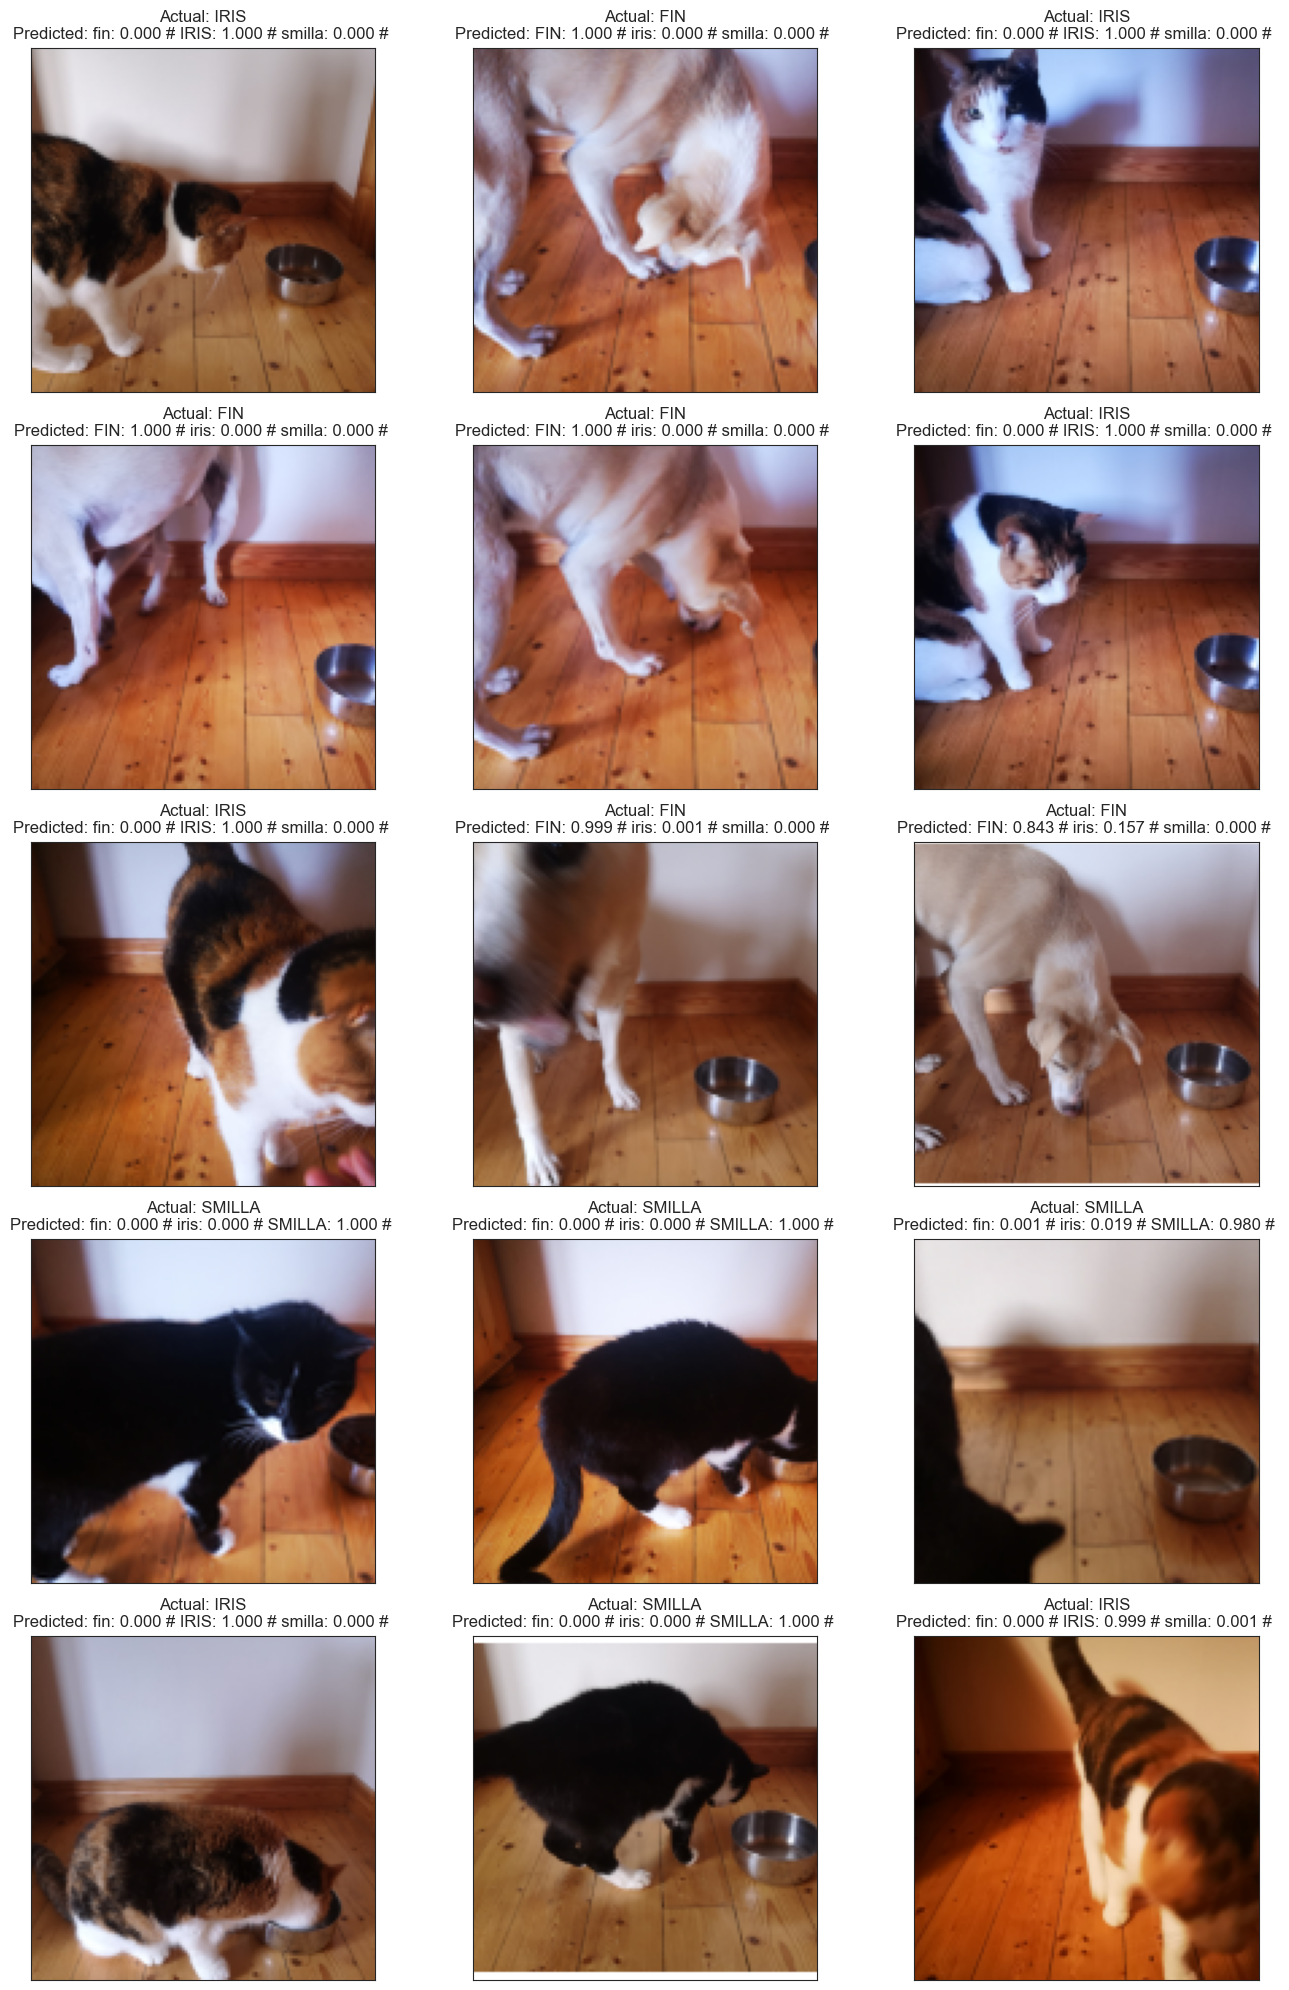

In [51]:
sns.set_style('white')
save = False
# Figure properties
# Note: sample amount must be divisible by 3 to fit into three columns
sample_amount = 15
nrows = sample_amount//3
coords = itertools.product(range(nrows), range(3))
# Sample random images and assign correct labels
img_idx = random.sample(range(0, X_test.shape[0]), k=sample_amount)
sample_imgs = np.array([X_test[i] for i in img_idx])
y_true = [y_ohe_test.loc[i].idxmax() for i in img_idx]
# Predict the classes of the sample images
y_pred = model.predict(sample_imgs, verbose=3)

fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows*5))
for coord, label, pred, img in zip(coords, y_true, y_pred, sample_imgs):
    title_str = f'Actual: {label.upper()}\nPredicted: '
    for i, cl in CLASS_DICT.items():
        title_str += f'{cl.upper() if pred[i]==pred.max() else cl}: {pred[i]:.3f} # '
    axes[coord[0], coord[1]].set_title(title_str)
    axes[coord[0], coord[1]].imshow(img)
    set_ticks(axes[coord[0], coord[1]])
plt.tight_layout(rect=[0, 0.1, 0.9, 0.9])
if save:
    plt.savefig(f'{output_path}/pred_test_montage.png')
plt.show()
    


### Evaluate the test subset class predictions

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Create a confusion matrix and a classification report for the test images.

In [228]:
save = False
# Create numpy array with test image class predictions
y_pred_raw = model.predict(X_test, verbose=3)
# Transform into a DataFrame with class names
y_pred = pd.DataFrame([CLASS_DICT[i] for i in np.argmax(y_pred_raw, axis=1)], columns=[''])
# Get a DataFrame with the actual class names
y_true = pd.from_dummies(y_ohe_test)

idx = [f'Actually {label}' for label in LABELS]
col = [f'Predicted {label}' for label in LABELS]

# Compare both DataFrames in a confusion matrix
conf_matrix = pd.DataFrame(confusion_matrix(y_true, y_pred), index=idx, columns=col)
# Create a classification report to see the model accuracy
class_report = classification_report(y_true, y_pred, target_names=LABELS)

print('\nConfusion matrix: \n')
print(conf_matrix)
print('\nClassification report: \n')
print(class_report)

if save:
    joblib.dump(f'Confusion matrix:\n\n{conf_matrix.to_string()} \n\nClassification report:\n\n {class_report}', f'{output_path}/test_class_report.pkl')
    


Confusion matrix: 

                 Predicted fin  Predicted iris  Predicted smilla
Actually fin               166               7                 0
Actually iris                2             170                 1
Actually smilla              0               0               173

Classification report: 

              precision    recall  f1-score   support

         fin       0.99      0.96      0.97       173
        iris       0.96      0.98      0.97       173
      smilla       0.99      1.00      1.00       173

    accuracy                           0.98       519
   macro avg       0.98      0.98      0.98       519
weighted avg       0.98      0.98      0.98       519



### Precision heatmap

d:\Projekte\Coding\CodeInstitute\PP5\.venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


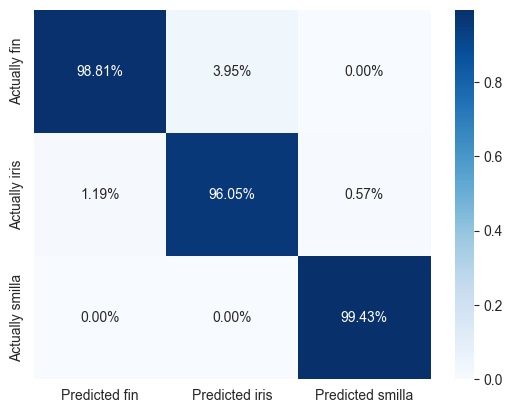

In [101]:
# Show precision in heat map
save = True
c_m = pd.DataFrame(confusion_matrix(y_true, y_pred), index=idx, columns=col)
sns.heatmap(c_m/np.sum(c_m), annot=True, fmt='.2%', cmap='Blues')
if save:
    plt.savefig(f'{output_path}/pred_test_precision_heatmap.png')
plt.show()

### Overall classification heatmap

In [102]:
# Prepare classification report for heatmap visualization
cr = classification_report(y_true, y_pred, target_names=LABELS, output_dict=True)
df_cr = pd.DataFrame.from_dict(cr)
df_cr.drop(index=['support'], axis=0, inplace=True)
df_cr.drop(columns=['macro avg', 'weighted avg', 'accuracy'], axis=1, inplace=True)
df_cr = df_cr.apply(lambda x: x*100)

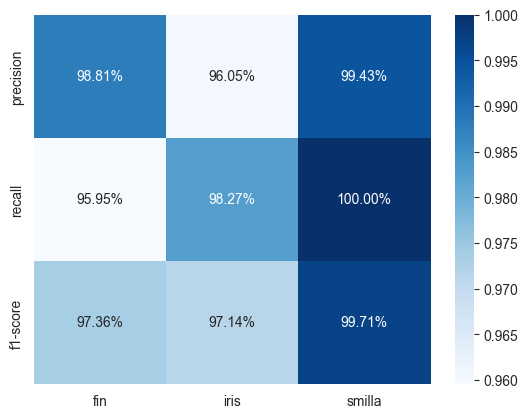

In [103]:
# Show precision in heat map
save = True
sns.heatmap(df_cr/100, annot=True, fmt='.2%', cmap='Blues')
if save:
    plt.savefig(f'{output_path}/pred_test_classification_heatmap.png')
plt.show()


### Images that were falsely classified

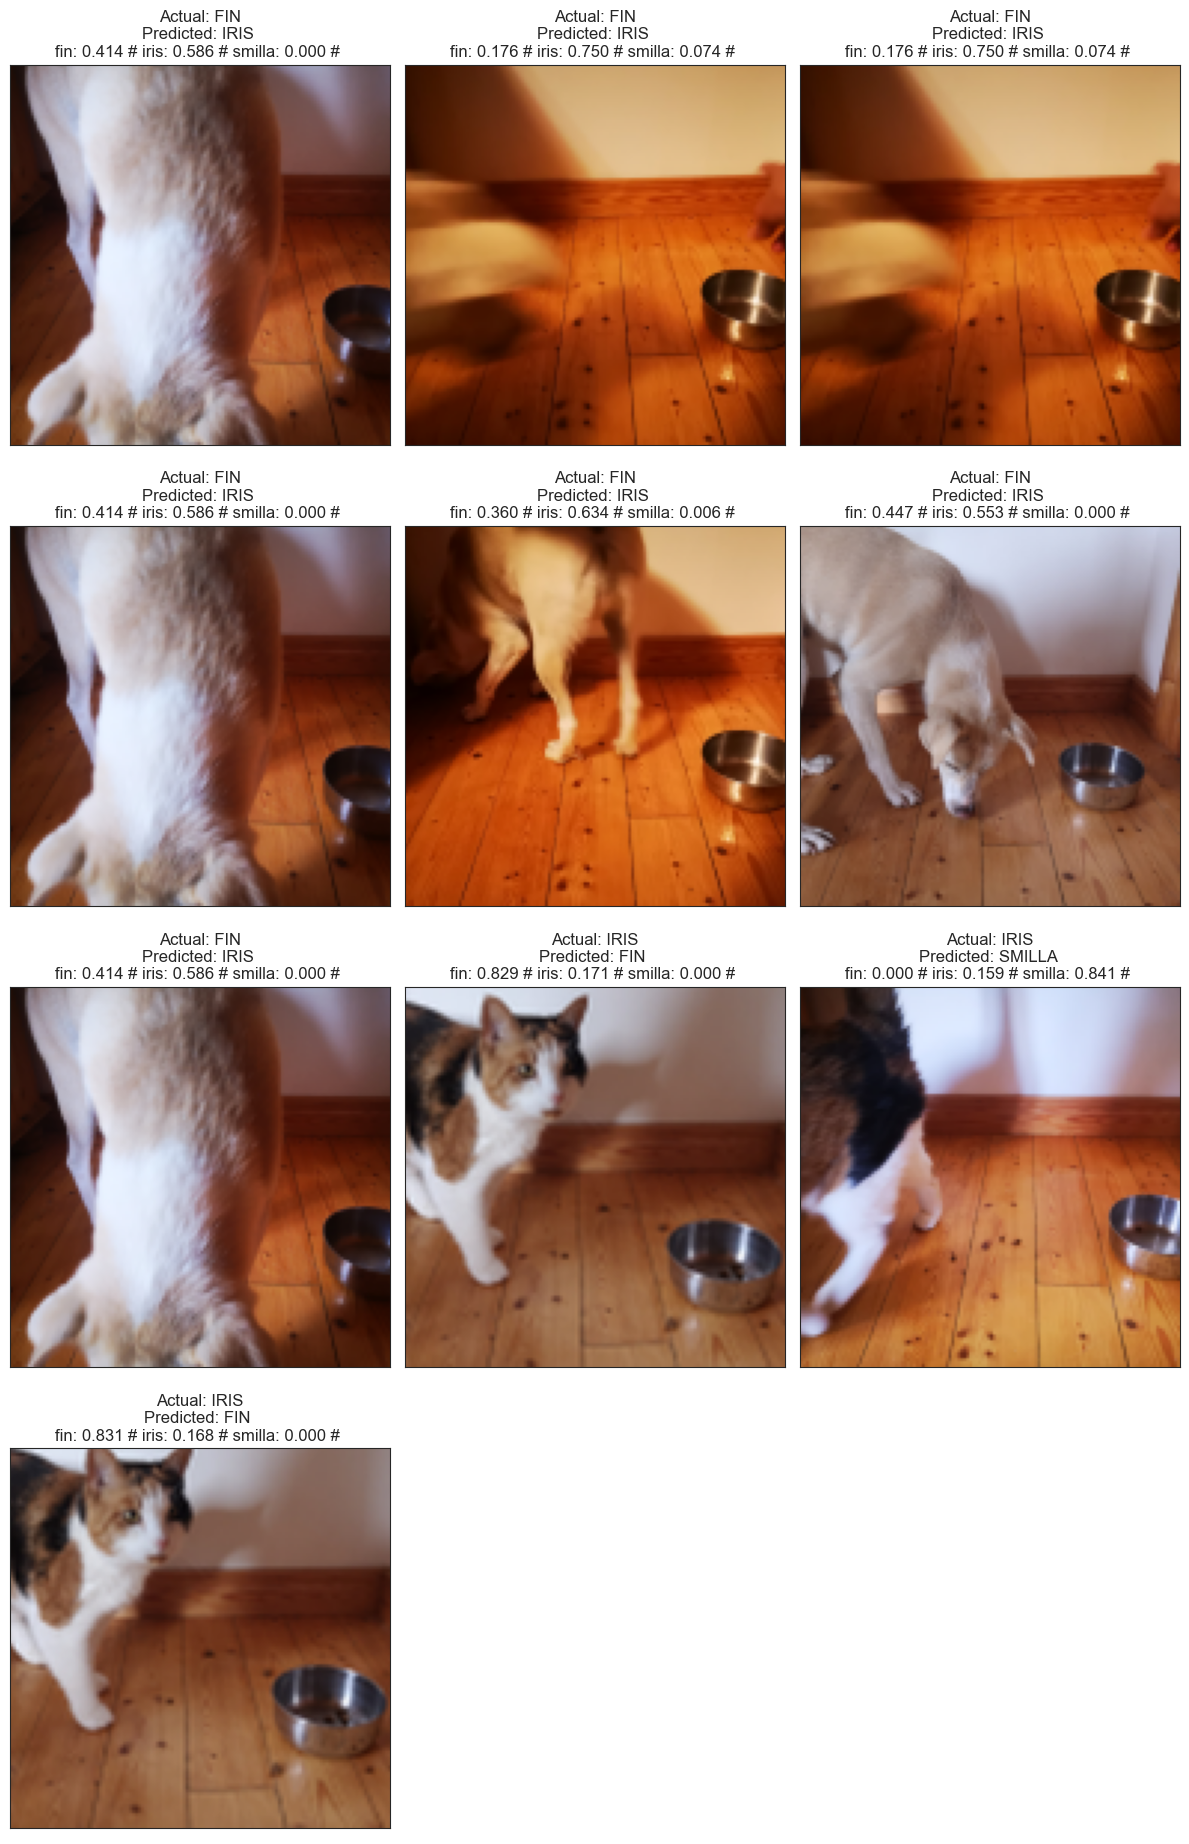

In [148]:
save = False

# Compare both DataFrames
diff = y_true.compare(y_pred)
diff.sort_values(by=('', 'self'), axis=0, inplace=True)
diff_label_pairs = np.array(diff)
diff_len = len(diff_label_pairs)
# Figure properties
nrows = diff_len//3 + (1 if diff_len%3 else 0)
coords = list(itertools.product(range(nrows), range(3)))[:diff_len]

fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows*5))
for ax in axes.flatten():
    ax.axis('off')
for coord, idx, labs in zip(coords, diff.index, diff_label_pairs):
    title_str = f'Actual: {labs[0].upper()}\nPredicted: {labs[1].upper()} \n'
    for i, cl in CLASS_DICT.items():
        title_str += f'{cl}: {y_pred_raw[idx][i]:.3f} # '
    axes[coord[0], coord[1]].set_title(title_str)
    axes[coord[0], coord[1]].imshow(X_test[idx])
    set_ticks(axes[coord[0], coord[1]])
plt.tight_layout(rect=[0, 0.05, 0.8, 0.98])
if save:
    plt.savefig(f'{output_path}/pred_diff_test_montage.png')
plt.show()


### Images with low confidence

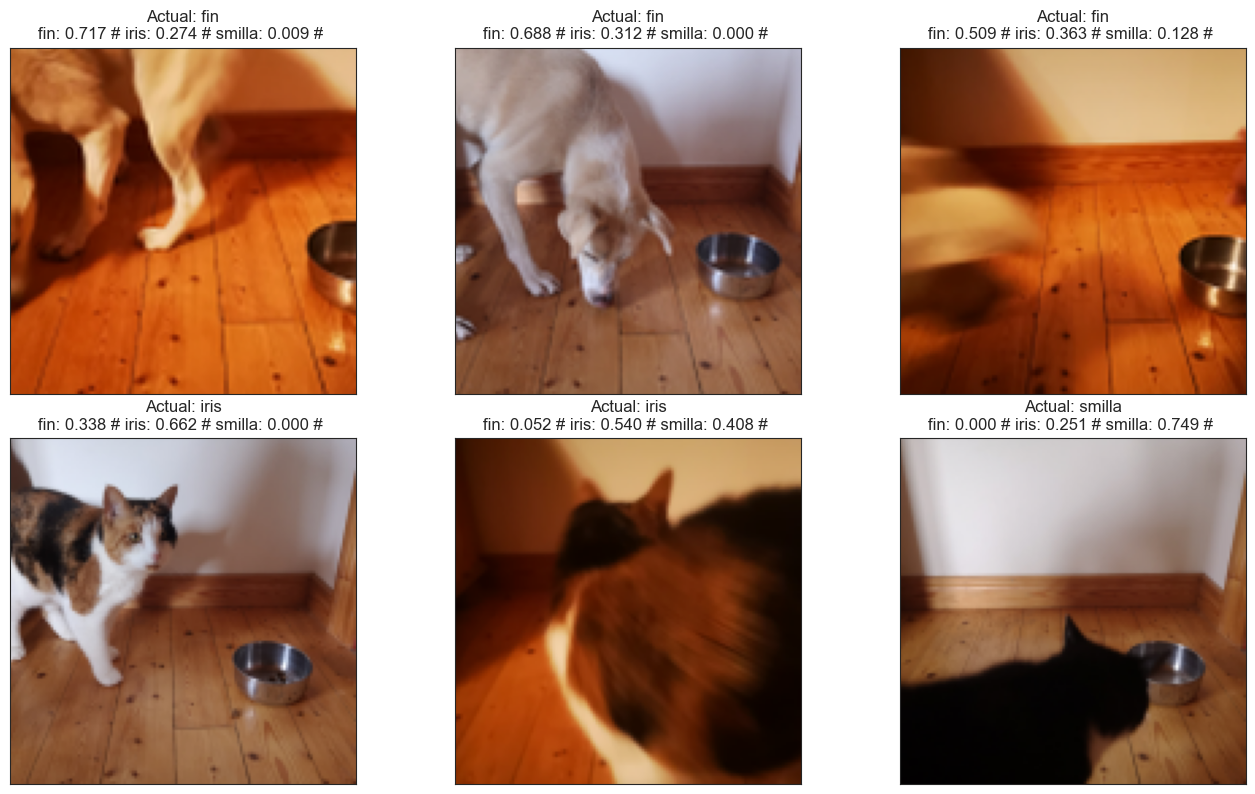

In [139]:
save = True

max_vals = y_pred_raw.max(axis=1)
unsure_idx = np.argwhere(max_vals < 0.75).flatten()
unsure_idx = ([x for x in unsure_idx if x not in list(diff.index)])
all_labels = y_true.to_numpy().flatten()
unsure_labels = [all_labels[i] for i in unsure_idx]
unsure_idx, unsure_labels = list(zip(*sorted(zip(unsure_idx, unsure_labels), key=lambda x: x[1])))
unsure_len = len(unsure_idx)
nrows = unsure_len//3 + (1 if unsure_len%3 else 0)
coords = list(itertools.product(range(nrows), range(3)))[:unsure_len]

fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows*5))
for ax in axes.flatten():
    ax.axis('off')
for coord, idx, labs in zip(coords, unsure_idx, unsure_labels):
    title_str = f'Actual: {labs}\n'
    for i, cl in CLASS_DICT.items():
        title_str += f'{cl}: {y_pred_raw[idx][i]:.3f} # '
    axes[coord[0], coord[1]].set_title(title_str)
    axes[coord[0], coord[1]].imshow(X_test[idx])
    set_ticks(axes[coord[0], coord[1]])
plt.tight_layout(rect=[0, 0.1, 0.9, 0.9])
if save:
    plt.savefig(f'{output_path}/pred_unsure_test_montage.png')
plt.show()

### Test model with live data

In [13]:
from PIL.Image import UnidentifiedImageError

def save_live_data(path, shape):
    #X, y = np.array([], dtype='int'), np.array([], dtype='object')
    Xy_dict = {}
    dims = shape[1:3]
    for label in os.listdir(path):
        img_list = os.listdir(os.path.join(path, label))
        Xy_dict[label] = np.array([], dtype='int')
        
        print(f'\nImporting from label "{label}..."')
        progress_bar = show_progress(len(img_list))
        img_counter = 0
        errors = []

        for img_name in img_list:
            try:
                img = image.load_img(os.path.join(path, label, img_name))
            except UnidentifiedImageError as e:
                errors.append(f'{e} :: {img_name} >> skipped')
                continue
            if img.size != (dims):
                img = img.resize(dims, resample=Image.LANCZOS)
            img_resized = image.img_to_array(img)
            if img_resized.max() > 1:
                img_resized = img_resized / 255
            
            img_counter += 1
            Xy_dict[label] = np.append(Xy_dict[label], img_resized)
            
            print(next(progress_bar), end='')
        
        # Exhaust the generator
        try:
            rest = [p for p in progress_bar]
            print(''.join(rest), end='')
        except StopIteration:
            pass
        
        print(f"{img_counter} images loaded")
        if errors:
            print_err('\n'.join(errors))
        
        Xy_dict[label] = Xy_dict[label].reshape(shape)

    print('\nLive data loaded.')
    
    return Xy_dict

We import the live images from the live folder and save them in a dictionary.


Importing from label "fin..."
####################################################################################################|| 58 images loaded

Importing from label "iris..."
####################################################################################################|| 53 images loaded

Importing from label "smilla..."
####################################################################################################|| 77 images loaded
ERROR:
cannot identify image file <_io.BytesIO object at 0x00000208521E7EC0> :: img_set_shape_extra - Kopie - Kopie (2).pkl >> skipped

Live data loaded.

Shape of label iris: (53, 128, 128, 3)


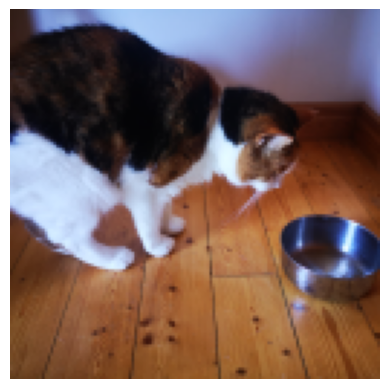

In [14]:
live_path = os.path.join(cwd,'live_img')
X_y_live = save_live_data(live_path, INPUT_SHAPE)

# Check if the images have been loaded correctly
rnd_label = random.choice(list(X_y_live.keys()))
print(f'\nShape of label {rnd_label}: {X_y_live.get(rnd_label).shape}')
plt.imshow(random.choice(X_y_live.get(rnd_label)))
plt.axis('off')
plt.show()


In [117]:
from collections import Counter

save=False

sns.set_style("white")

X_live = np.array([])
y_true = np.array([])

for label in LABELS:
    X_live = np.append(X_live, X_y_live[label]).reshape(INPUT_SHAPE)
    #y_ohe_live = np.array([ohe_map[label]]*len(live_set_by_labels[label]))
    y_true = np.append(y_true, [label]*len(X_y_live[label])).reshape(-1)

print(f'Live data shape: {X_live.shape}')
print('\nLive data stats: \n')

print(pd.DataFrame.from_dict(Counter(y_true), columns=['Amount'], orient='index'))
print('')

# Predict the classes of live images and save the raw predictions in a numpy array
y_pred = model.predict(X_live, verbose=0)

# Convert the predictions into a DataFrame with class names
y_pred = pd.DataFrame(np.array([CLASS_DICT[i] for i in np.argmax(y_pred, axis=1)]))

idx = [f'Actually {label}' for label in LABELS]
col = [f'Predicted {label}' for label in LABELS]

# Compare both DataFrames in a confusion matrix
conf_matrix = pd.DataFrame(confusion_matrix(y_true, y_pred), index=idx, columns=col)
# Create a classification report to see the model accuracy
class_report = classification_report(y_true, y_pred, target_names=LABELS)

print('\nConfusion matrix: \n')
print(conf_matrix)
print('\nClassification report: \n')
print(class_report)

if save:
    joblib.dump(f'Confusion matrix:\n\n{conf_matrix.to_string()} \n\nClassification report:\n\n {class_report}', f'{output_path}/live_class_report.pkl')

Live data shape: (188, 128, 128, 3)

Live data stats: 

        Amount
fin         58
iris        53
smilla      77


Confusion matrix: 

                 Predicted fin  Predicted iris  Predicted smilla
Actually fin                51               7                 0
Actually iris                0              52                 1
Actually smilla              0               1                76

Classification report: 

              precision    recall  f1-score   support

         fin       1.00      0.88      0.94        58
        iris       0.87      0.98      0.92        53
      smilla       0.99      0.99      0.99        77

    accuracy                           0.95       188
   macro avg       0.95      0.95      0.95       188
weighted avg       0.96      0.95      0.95       188



#### Live data precision heatmap

d:\Projekte\Coding\CodeInstitute\PP5\.venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


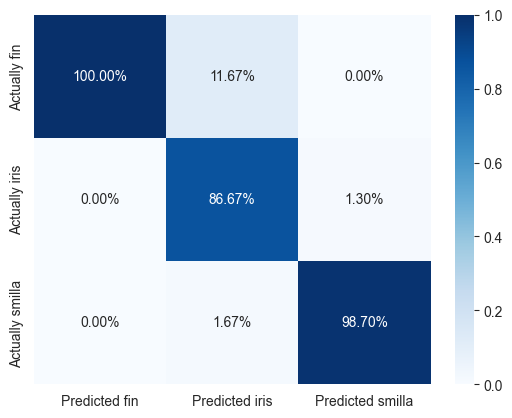

In [17]:
# Show precision in heat map
save = False
c_m = pd.DataFrame(confusion_matrix(y_true, y_pred), index=idx, columns=col)
sns.heatmap(c_m/np.sum(c_m), annot=True, fmt='.2%', cmap='Blues')
if save:
    plt.savefig(f'{output_path}/pred_live_precision_heatmap.png')
plt.show()

#### Live data classification heatmap

In [18]:
# Prepare classification report for heatmap visualization
cr = classification_report(y_true, y_pred, target_names=LABELS, output_dict=True)
df_cr = pd.DataFrame.from_dict(cr)
df_cr.drop(index=['support'], axis=0, inplace=True)
df_cr.drop(columns=['macro avg', 'weighted avg', 'accuracy'], axis=1, inplace=True)
df_cr = df_cr.apply(lambda x: x*100)

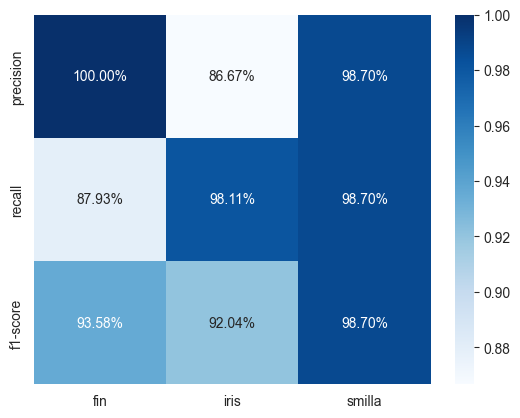

In [19]:
# Show precision in heat map
save = False
sns.heatmap(df_cr/100, annot=True, fmt='.2%', cmap='Blues')
if save:
    plt.savefig(f'{output_path}/pred_live_classification_heatmap.png')
plt.show()


In [373]:
# #ohe_map = joblib.load(f'{output_path}/ohe_map.pkl')
# start = 5
# end = 15
# y_ohe_live = np.array([ohe_map['smilla']]*(end-start))
# print(y_ohe_live)


In [126]:
# Predict by label batches
import functools as ft

#X_y_live.items()
def X_gen(X_y_live, label):
    #label = random.choice(LABELS)
    #label = 'iris'
    # if img_count > 3 and img_count < 6:
    #     label = 'smilla'
    amount = len(X_y_live[label])
    num = random.randint(0, amount - 1)
    return np.expand_dims(X_y_live[label][num], axis=0), label

#get_X_gen = X_gen(X_y_live)


result = ''

for label in LABELS:
    img_amounts = []

    for _ in range(10):
        img_count = 0
        std_sum = []

        while True:
            img_count += 1
            img, label = X_gen(X_y_live, label)
            y_pred_sg = model.predict(img, verbose=3)
            std_sum.append(y_pred_sg)
            #print(f'Classifying image nr {img_count} ... ({label})')
            if len(std_sum) > 10:
                print('current mean of the batch: ')
                cur_mean = np.around(np.mean(std_sum, axis=0)*100, 2).flatten()
                print(cur_mean)
                fav_class = np.argmax(cur_mean)
                print('Favoured class: ', fav_class)
                cur_var = np.around(np.var(std_sum, axis=0)*100).flatten()
                print('Current var: ', cur_var)
                cur_std = np.around(np.std(std_sum, axis=0)*100).flatten()
                print('Current std: ', cur_std)

                if (cur_mean[fav_class] > 75 and cur_std[fav_class] < 50 and cur_var[fav_class] < 20) or len(std_sum) >= 30:
                    if len(std_sum) >= 20:
                        print('Cancelling classification attempt after 30 trials.')
                        print(f'Mean {cur_mean[fav_class]}, Class {CLASS_DICT[fav_class]}, Std {cur_std[fav_class]}, Var {cur_var[fav_class]}')
                        img_amounts.append(0)
                        break
                    else:
                        print(f'Classification complete: {CLASS_DICT[fav_class]}\n Mean {cur_mean[fav_class]}, Class {fav_class}, Std {cur_std[fav_class]} Var {cur_var[fav_class]}')
                        img_amounts.append([img_count, CLASS_DICT[fav_class], cur_mean[fav_class]])
                        break
                else:
                    print(f'Unsure yet: Mean {cur_mean[fav_class]}, Class {CLASS_DICT[fav_class]}, Std {cur_std[fav_class]} Var {cur_var[fav_class]}')
    result += f'{label}: \n {img_amounts} \n'

print(result)

current mean of the batch: 
[91.72  8.27  0.  ]
Favoured class:  0
Current var:  [6. 6. 0.]
Current std:  [25. 25.  0.]
Classification complete: fin
 Mean 91.72000122070312, Class 0, Std 25.0 Var 6.0
current mean of the batch: 
[85.89 13.91  0.2 ]
Favoured class:  0
Current var:  [9. 9. 0.]
Current std:  [30. 30.  1.]
Classification complete: fin
 Mean 85.88999938964844, Class 0, Std 30.0 Var 9.0
current mean of the batch: 
[9.556e+01 4.430e+00 1.000e-02]
Favoured class:  0
Current var:  [2. 2. 0.]
Current std:  [13. 13.  0.]
Classification complete: fin
 Mean 95.55999755859375, Class 0, Std 13.0 Var 2.0
current mean of the batch: 
[89.73 10.27  0.  ]
Favoured class:  0
Current var:  [7. 7. 0.]
Current std:  [27. 27.  0.]
Classification complete: fin
 Mean 89.7300033569336, Class 0, Std 27.0 Var 7.0
current mean of the batch: 
[8.623e+01 1.375e+01 3.000e-02]
Favoured class:  0
Current var:  [8. 8. 0.]
Current std:  [29. 29.  0.]
Classification complete: fin
 Mean 86.2300033569336, Clas

In [ ]:
 
'''

save = False

sns.set_style("whitegrid")

ohe_map = joblib.load(f'{output_path}/ohe_map.pkl')
all_confs = {'true': [], 'pred': []}

for label_name, img_set in X_y_live.items():
    
    conf_sum = 0
    
    batch_amount = 5
    sample_amount = 10
#    fig, ax = plt.subplots()
    all_means = []
    all_vars = []
    batch_probas = []

    for b_num in range(0, batch_amount):
        img_batch = random.randint(0, len(img_set) - sample_amount)
        start = img_batch
        end = img_batch + sample_amount
        y_ohe_live = np.array([ohe_map[label_name]]*(end-start))
        #y_ohe_live = ohe_map[label_name]*[start:end]



        std_sum = []
        all_dict = {'': []}
        
        for img in img_set[start:end]:
            img = np.expand_dims(img, axis=0)
            y_pred_sg = model.predict(img, verbose=3)
            std_sum.append(y_pred_sg)
            #print(CLASS_DICT[np.argmax(y_pred_sg)])
            print('new mean of the batch: ')
            print(np.around(np.mean(std_sum, axis=0)*100, 2))
            print('new std of the batch: ')
            print(np.around(np.std(std_sum, axis=0)*100, 2))
            print('new var of the batch: ')
            print(np.around(np.var(std_sum, axis=0)*100, 2))
            all_dict.setdefault(CLASS_DICT[np.argmax(y_pred_sg)], []).append(np.amax(y_pred_sg))
            #print(np.amax(y_pred_sg))
            #std_sum.append(np.amax(y_pred_sg))
            #if np.std(std_sum) > 0.05:
            #    print('New deviation: ', np.std(std_sum))

        print(all_dict)

        print('Resulting mean: ', np.around(np.mean(std_sum, axis=0)*100))
        print('Resulting var: ', np.around(np.var(std_sum, axis=0)*100))
        print('Resulting std: ', np.around(np.std(std_sum, axis=0)*100))
        print('Resulting med: ', np.around(np.median(std_sum, axis=0)*100))
        
            
        continue
    
    #break
    
    '''
    
'''

        y_pred = model.predict(img_set[start:end], verbose=3)
        ### NEW:
        class_dict = {0: 'fin', 1: 'iris', 2: 'smilla'}
        pred_df = pd.DataFrame(np.array([class_dict[i] for i in np.argmax(y_pred, axis=1)]))
        #print(pred_df)
        pred_list = np.array([class_dict[i] for i in np.argmax(y_pred, axis=1)])
        #print(pred_list)
        
        # y_ohe_live = y_labels[key]

        # X_pred = model.predict(value, verbose=3)


        #print(X_pred[:2])
        #print(y_ohe_live[:5])

        X_pred_2 = np.round(y_pred, 2)
        df_pred = pd.DataFrame(X_pred_2, columns=LABELS)

        class_dict = joblib.load(f'{output_path}/class_dict.pkl') #{0: 'Fin', 1: 'Iris', 2: 'Smilla'}

        new_labels = pd.DataFrame(np.array(y_ohe_live), columns=LABELS)
        new_labels['unknown'] = 0
        #print(new_labels)
        y_true = pd.from_dummies(new_labels)
        #print(f'labels: {labels}')

        #print((X_pred[0]))
        #print((X_pred[0][0]))
        # X_pred_2 = np.round(X_pred, 2)
        # df_pred = pd.DataFrame(X_pred_2, columns=['Fin', 'Iris', 'Smilla'])
        #batch_details[batch_idx] = 
        #print(np.array(df_pred[label_name]))
        ax.step(x=range(0, sample_amount), y=df_pred[label_name], where='mid')
        ax.set_ylabel('Confidence')
        ax.set_xlabel('Image number')
        
        #df_pred[label_name].plot(kind='line', marker='^')
        
        result_nums = pd.Series(ft.reduce(lambda a, b: a+b, y_pred))
        result_value = result_nums.max()
        result_idx = result_nums.idxmax()

        # Needed for the boxplot
        current_batch_preds = pd.DataFrame(y_pred)[result_idx].to_numpy()
        batch_probas.append(current_batch_preds)
        #print('cbp', np.mean(current_batch_preds))
        #print('cbp-med', np.median(current_batch_preds))
        # calculate mean and variance of each y_pred column
        # do this instead of reduce
        means = (np.mean(np.around(y_pred, 3), axis=0))[result_idx] # pd.Series(ft.reduce(lambda a, b: a+b, y_pred))
        #print(means)# all_means.append(means)
        # vars = (np.std(np.around(y_pred, 3), axis=0))[result_idx] # pd.Series(ft.reduce(lambda a, b: a+b, y_pred))
        # # print(vars)
        # all_vars.append(vars)
        
        
        
        X_pred_1d = y_pred.reshape(-1)
        y_pred = np.array([1 if x > 0.75 else 0 for x in X_pred_1d]).astype('int').reshape(-1, 3) #1 X_pred.round(decimals=0).astype('int')
        #print(y_pred)
        result_nums_2 = pd.Series(ft.reduce(lambda a, b: a+b, y_pred))
        result_value_2 = result_nums_2.max()
        confidence_2 = result_value_2/len(y_ohe_live)
        result_idx_2 = result_nums_2.idxmax()
        
        #print('conf2: ', confidence_2)
        #print('pet2: ', label_dict[result_idx_2])
        
        confidence = result_value/len(y_ohe_live)
        pet_guess = class_dict[result_idx]
        #print(f'{confidence} - guessing {pet_guess} - actually: {label_name}')
        
        pet_pred = sorted(Counter(pred_list).items(), key=lambda x: x[1], reverse=True)[0][0]
        #print(f'{pet_pred} with argmax')
        
        #print(sorted(Counter(pred_list), key=lambda x: x[1] for x in x.items))
        all_confs['true'].append(label_name)
        #all_confs['pred'].append(pet_guess)
        all_confs['pred'].append(pet_pred)
        
        conf_sum += confidence
        #conf_sum_2 += confidence_2

        y_pred = pd.DataFrame(y_pred, columns=LABELS)
        #new_preds[new_preds.sum(axis=1) > 1] = [0, 0, 1]
        #print(new)
        y_pred['unknown'] = y_pred.apply(lambda x: 0 if sum(x.values) > 0 else 1, axis=1)
        # #print(new_preds)

        y_pred = pd.from_dummies(y_pred)
        # #print(y_p)
        #diff = y_true.compare(y_pred)
#        print('diff confidence:')
#        print(len(np.array(diff))/batch_amount)
            
            
            
            
            
    print(f'guessing {Counter(all_confs['pred'])} - actually: {label_name}')
    print('Overall confidence: ', conf_sum / batch_amount)
   # print('Overall confidence 2: ', conf_sum_2 / batch_amount)
    
    plt.yticks(np.arange(0, 1.2, 0.1))
    plt.xticks(np.arange(0, sample_amount, 1))
    plt.show()
    
    
    fig, ax = plt.subplots(figsize=(8, 5))
    for c, x in enumerate(batch_probas):
        plot = ax.boxplot(x, positions=[c], widths=0.5, showmeans=True, meanline=True, 
                          meanprops={
                              'linestyle': '-', 'color': 'firebrick', 'linewidth': 2}, 
                          medianprops={'linestyle': '-', 'color': 'green', 'linewidth': 1.5})
        ax.set_ylabel('Confidence')
        ax.set_xlabel('Batch number')
    plt.yticks(np.arange(0, 1.2, 0.1))
    plt.xticks(np.arange(0, batch_amount, 1))
    plt.show()

print(all_confs)

idx = [f'Actually {label}' for label in LABELS]
col = [f'Predicted {label}' for label in LABELS]

# Compare both DataFrames in a confusion matrix
conf_matrix = pd.DataFrame(confusion_matrix(all_confs['true'], all_confs['pred']), index=idx, columns=col)
# Create a classification report to see the model accuracy
class_report = classification_report(all_confs['true'], all_confs['pred'], target_names=LABELS)

print('\nConfusion matrix: \n')
print(conf_matrix)
print('\nClassification report: \n')
print(class_report)

if save:
    joblib.dump(f'Confusion matrix:\n\n{conf_matrix.to_string()} \n\nClassification report:\n\n {class_report}', f'{output_path}/live_class_report.pkl')

#print(pd.DataFrame(confusion_matrix(all_confs['true'], all_confs['pred']), index=idx, columns=col)) #, index=ix, columns=cl))
#print(classification_report(all_confs['true'], all_confs['pred'], target_names=LABELS))


'''

In [80]:

diff = y_true.compare(y_pred)

for i in diff.index:
    print(f'actual: {y_pred[i]}')
    print(f'predicted: Fin: {float(X_pred_2[i][0])*100} %, Iris: {float(X_pred_2[i][1])*100} %, Smilla: {float(X_pred_2[i][2])*100}%')
    plt.imshow(X_live[i])
    plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'compare'